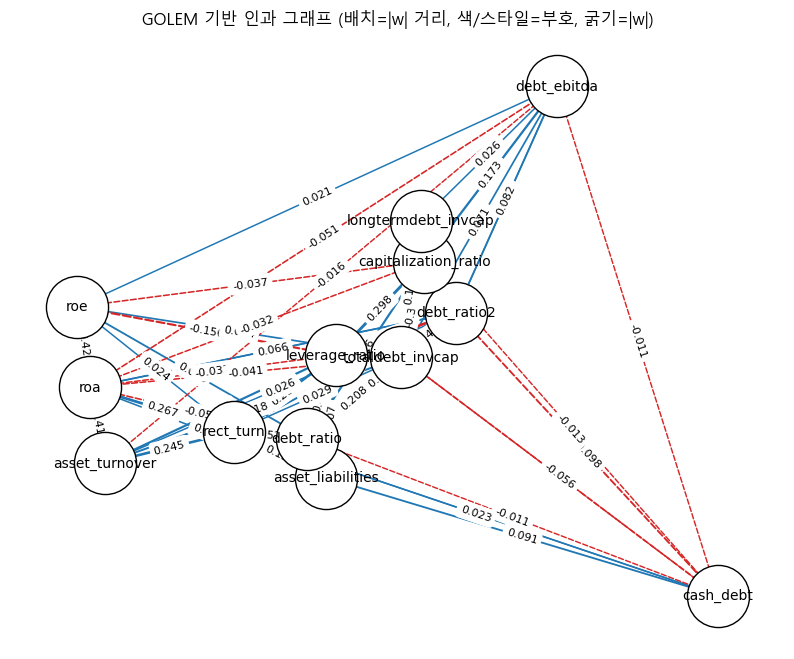

In [1]:
# =============================
# GES → GOLEM 대체 블록 (PyTorch)
# =============================
# (최초 1회) torch 설치가 안 되어 있다면:
# %pip install -q torch

import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# --- 시각화 설정 (선택) ---
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 0) 데이터 로드 (기존과 동일: df, feature_cols, X_base, y, cols_for_w, cols)
df = pd.read_csv("training_data.csv")
feature_cols = df.drop(columns=["Unnamed: 0", "label"]).columns
X_base = df[feature_cols].copy()
y = df["label"].astype(int)
cols_for_w = list(feature_cols)
cols = cols_for_w

# 1) 표준화 데이터 (GOLEM은 연속 최적화에서 스케일 영향 ↓)
Z = StandardScaler().fit_transform(X_base.values)  # (n, d)
n, d = Z.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_t = torch.tensor(Z, dtype=torch.float32, device=device)

# 2) GOLEM(EV) 목적함수 구성
#    - 재구성오차(0.5/n ||X - XW||_F^2)
#    - L1 (sparsity), L2 (ridge)
#    - 비순환 제약: h(W)=tr(exp(W∘W)) - d  (∘: elementwise)
#    - Augmented Lagrangian: μ*h + (ρ/2)h^2
lambda1 = 2e-2   # L1 sparsity (필요시 조정)
lambda2 = 5e-2   # L2 ridge     (필요시 조정)
lr = 2e-2
inner_steps = 1500   # 내부(Adam) 반복
max_outer = 8        # 바깥(라그랑주/패널티 갱신) 반복
h_tol = 1e-8
mu = 1.0
rho = 1.0

W_param = nn.Parameter(torch.zeros(d, d, device=device))
I = torch.eye(d, device=device)
mask_offdiag = (1.0 - torch.eye(d, device=device))  # 대각선 0 유지용 마스크
optimizer = optim.Adam([W_param], lr=lr)

def acyclicity(W_eff: torch.Tensor) -> torch.Tensor:
    M = W_eff * W_eff  # elementwise square
    return torch.trace(torch.matrix_exp(M)) - d

def loss_fn(W_eff: torch.Tensor) -> torch.Tensor:
    # 재구성오차
    recon = 0.5 / n * torch.sum((X_t - X_t @ W_eff) ** 2)
    # 정규화
    l1 = lambda1 * torch.sum(torch.abs(W_eff))
    l2 = 0.5 * lambda2 * torch.sum(W_eff ** 2)
    # 비순환
    h = acyclicity(W_eff)
    aug = mu * h + 0.5 * rho * h * h
    return recon + l1 + l2 + aug, h, recon

best_loss = float('inf')
with torch.enable_grad():
    for outer in range(max_outer):
        for step in range(inner_steps):
            optimizer.zero_grad()
            W_eff = W_param * mask_offdiag  # 대각 0 강제
            loss, h_val, recon = loss_fn(W_eff)
            loss.backward()
            optimizer.step()

            # 대각 0 강제(수치오차 cleanup)
            with torch.no_grad():
                W_param.data = W_param.data * mask_offdiag

            if loss.item() < best_loss:
                best_loss = loss.item()

        # AugLag 업데이트
        with torch.no_grad():
            W_eff = W_param * mask_offdiag
            h_curr = acyclicity(W_eff).item()
        if h_curr <= h_tol:
            # 충분히 DAG에 가까우면 종료
            break
        mu = mu + rho * h_curr
        rho *= 10.0  # 점진적 패널티 강화

# 3) 결과 행렬 W 추출 (numpy)
W_golem = (W_param * mask_offdiag).detach().cpu().numpy()

# 4) 시각화 파라미터
USE_QUANTILE = False     # True면 분위수 임계 사용
W_THRESHOLD = 0.01       # |W| > 0.01
W_ABS_QUANTILE = 0.90    # USE_QUANTILE=True일 때 상위 10%

def get_threshold(W, fixed=W_THRESHOLD, use_q=USE_QUANTILE, q=W_ABS_QUANTILE):
    if not use_q:
        return fixed
    aw = np.abs(W).ravel()
    aw = aw[aw > 0]
    return float(np.quantile(aw, q)) if aw.size else fixed

thr = get_threshold(W_golem)

# 5) 그래프 구성 (부호 유지), 레이아웃은 |w| 기반 양의 '거리'로 안정화
G = nx.DiGraph()
edges_all = []
for i in range(d):
    for j in range(d):
        if i == j:
            continue
        w = float(W_golem[i, j])  # i <- j
        if abs(w) > thr:
            u = cols[j]  # parent
            v = cols[i]  # child
            edges_all.append((u, v, w))
            G.add_edge(u, v, weight=round(w, 3))

# 배치용 보조 그래프(H): 거리=1/(|w|+ε)
eps = 1e-6
H = nx.Graph()
for u, v, data in G.edges(data=True):
    w = data.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')  # 안정적 배치

# 부호/크기 스타일
max_abs = max((abs(d["weight"]) for _, _, d in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] >= 0]
neg_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title("GOLEM 기반 인과 그래프 (배치=|w| 거리, 색/스타일=부호, 굵기=|w|)")
plt.axis("off")
plt.show()

# 6) 저장 (아래 파이프라인에서 그대로 재사용)
Path("exp_outputs_svm_linear").mkdir(parents=True, exist_ok=True)
np.save("exp_outputs_svm_linear/W.npy", W_golem)
# 기존 변수명도 유지
W = W_golem
